In [15]:
## import packages 

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import networkx as nx
from tqdm import tqdm 
import psycopg2 
from collections import Counter
import plotly.graph_objects as go

main_path = "/home/fs01/spec1142/Emma/GateKeepers/"

f = open(main_path + "database.txt", "r")
user , password = f.read().split()


## Load SI data

In [3]:
## load SI files 

df_gatekeepers = pd.read_csv(main_path+ "gatekeepers_intermediate_clean_v5.tsv" , delimiter = "\t")
df_gatekeepers = df_gatekeepers[df_gatekeepers['number of match'] / df_gatekeepers['number of comparison'] > 0.5]

In [4]:
## group SIs by transitivity 

data_test = df_gatekeepers[["inventor_id" , "author_id"]].to_numpy()

cluster_test = []
G = nx.Graph()
G.add_edges_from(data_test)
count = 0 
for connected_component in nx.connected_components(G):
    cluster_test.append(connected_component)
    
dic_inventor_name = df_gatekeepers[["inventor_id" , "inventor_name"]].drop_duplicates("inventor_id").set_index("inventor_id").to_dict("index")
dic_author_name = df_gatekeepers[["author_id" , "author_name"]].drop_duplicates("author_id").set_index("author_id").to_dict("index")

dic_clusters = {}
count = 0 

for cluster in tqdm(cluster_test):
    dic_clusters[count] = {}
    dic_clusters[count]["OA"] = []
    dic_clusters[count]["PV"] = []
    for elem in cluster:
        
        if elem[0] == "A":
            dic_clusters[count]["OA"].append(  ( elem , dic_author_name[elem]) )
        else:
            dic_clusters[count]["PV"].append( ( elem ,  dic_inventor_name[elem]))
        
    count += 1



100%|████████████████████████████████| 581566/581566 [00:06<00:00, 85672.33it/s]


## Get OA and PV data 

In [5]:
## identify SIs named 'Doudna'

name = 'doudna'
list_SIs = []

for count in dic_clusters:
    list_author_names = set([ elem[1]['author_name'] for elem in dic_clusters[count]["OA"] ])
    list_inventor_names = set([ elem[1]['inventor_name'] for elem in dic_clusters[count]["PV"] ])
    for elem in list_author_names:
        if name in elem:
            list_SIs.append(count)
            print(elem)
    for elem in list_inventor_names:
        if name in elem:
            list_SIs.append(count)
            print(elem)

list_gk_authors = [ elem[0] for count in list_SIs for elem in dic_clusters[count]["OA"] ]
list_gk_inventors = [ elem[0] for count in list_SIs for elem in dic_clusters[count]["PV"] ]


jennifer a doudna
jennifer a doudna
james h doudna cate


In [18]:
list_gk_authors

['A5067184382', 'A5067184382', 'A5002871744', 'A5033210199']

In [10]:
## query PatentsView: get all inventor's patents written by inventors named Doudna

last_name = 'doudna' 
first_name = ''

conn = psycopg2.connect(database="spec1142", user=user , password=password , host="192.168.100.54")       
cursor = conn.cursor()

sql ="""SELECT DISTINCT  i.inventor_id , 
                 i.disambig_inventor_name_first , 
                 i.disambig_inventor_name_last ,
                 array_agg(a.disambig_assignee_organization)  ,
                 count(p.patent_id)

              FROM inventors_PatentsView as i

              JOIN patents_PatentsView as p ON i.patent_id = p.patent_id

              JOIN assignees_PatentsView as a ON p.patent_id = a.patent_id

              WHERE (f_unaccent(i.disambig_inventor_name_last) ILIKE '% """ + last_name + """ %'
              
              OR f_unaccent(i.disambig_inventor_name_last) ILIKE '""" + last_name + """ %'

              OR f_unaccent(i.disambig_inventor_name_last) ILIKE '""" + last_name + """'
              
              OR f_unaccent(i.disambig_inventor_name_last) ILIKE '% """ + last_name + """')

              GROUP BY i.inventor_id , 
                 i.disambig_inventor_name_first , 
                 i.disambig_inventor_name_last 
                 

              ;"""

cursor.execute(sql)
result = cursor.fetchall()



## query PatentsView: also get the patents written by the inventor in SIs clusters (if not already queried)

for inventor_id in list_gk_inventors:

    if inventor_id not in [ elem[0] for elem in result]:

        #Creating table as per requirement
        sql ="""SELECT DISTINCT  i.inventor_id , 
                         i.disambig_inventor_name_first , 
                         i.disambig_inventor_name_last ,
                         array_agg(a.disambig_assignee_organization)  ,
                         count(p.patent_id)
        
                      FROM inventors_PatentsView as i
        
                      JOIN patents_PatentsView as p ON i.patent_id = p.patent_id
        
                      JOIN assignees_PatentsView as a ON p.patent_id = a.patent_id
        
                      WHERE inventor_id = '""" + inventor_id + """'
        
                      GROUP BY i.inventor_id , 
                         i.disambig_inventor_name_first , 
                         i.disambig_inventor_name_last 
                         
        
                      ;"""
        cursor.execute(sql)
        result += cursor.fetchall()



## organize and store the results 

list_inventors = []

for elem in result:
    list_inventors.append(elem)


for k in range(len(list_inventors)):
    list_inventors[k]= [ list_inventors[k][0] , list_inventors[k][1], list_inventors[k][2], [ elem for elem in  list_inventors[k][3] if elem != ''], list_inventors[k][4] ] 



In [14]:
## query OpenAlex: get all author's papers written by authors named Doudna

conn = psycopg2.connect(database="spec1142", user=user , password=password , host="192.168.100.54")
        
cursor = conn.cursor()

sql  = """SELECT   a.author_id ,
                           a.display_name , 
                           a.orcid , 
                           a.last_known_institution_id , 
                           a.last_known_institution_display_name,
                           a.works_count
                           

              FROM authors_OpenAlex AS a

              WHERE ( f_unaccent(a.display_name) ILIKE '""" + last_name + """ %'
          
              OR f_unaccent(a.display_name) ILIKE '% """ + last_name + """'
    
              OR f_unaccent(a.display_name) ILIKE '% """ + last_name + """ %') 

              ;"""

cursor.execute(sql)
result = cursor.fetchall()


## query OpenAlex: also get the papers written by the author in SIs clusters (if not already queried)


for author_id in list_gk_authors:

    if author_id not in [ elem[0] for elem in result ] :
        #Creating table as per requirement
        sql  = """SELECT   a.author_id ,
                                   a.display_name , 
                                   a.orcid , 
                                   a.last_known_institution_id , 
                                   a.last_known_institution_display_name,
                                   a.works_count
                                   
        
                      FROM authors_OpenAlex AS a
        
                      WHERE author_id = '""" + author_id + """'
        
                      ;"""
    
        cursor.execute(sql)
        result += cursor.fetchall()  

    

## organize and store the results 

list_authors = []

for elem in result:
    list_authors.append(elem)

list_authors = [ (elem[0] , elem[1] , elem[4], elem[5]) for elem in list_authors if elem[4] != 'nan' ] 
list_authors

[('A5036859953', 'John W. Doudna', 'Iowa State University', 12),
 ('A5067214771', 'Kimberly Doudna', 'Western Michigan University', 10),
 ('A5067184382', 'Jennifer A. Doudna', 'Innovative Genomics Institute', 613),
 ('A5030756395', 'Gregory L. Doudna', 'Columbia University', 18),
 ('A5011030411', 'Doudna Ja', 'Innovative Genomics Institute', 4),
 ('A5018669260', 'J. H. Doudna', 'Lansing Community College', 15),
 ('A5025178623',
  'C. M. Doudna',
  'Missouri University of Science and Technology',
  16),
 ('A5008872247', 'Donald J. Doudna', 'Drake University', 4),
 ('A5033918340', 'Greg Doudna', 'Columbia University', 7),
 ('A5001804573',
  'Andrew H. Doudna Cate',
  'University of California, Berkeley',
  2),
 ('A5075501453', 'C Doudna', 'University of Illinois Urbana-Champaign', 4),
 ('A5004886658', 'Mark Doudna', 'The Ohio State University', 3),
 ('A5016159212', 'Aaron Doudna', 'Ohio University', 1),
 ('A5002871744', 'Jamie H. D. Cate', 'University of California, Berkeley', 75),
 ('A5

## Plot Sankey 

In [24]:
## organize the data for the Sankey 


## authors node labels 
labels_authors = { list_authors[k][1] + ' ' + list_authors[k][2] : k  for k in range(len(list_authors)) }

## inventors node labels 
labels_inventors = { list_inventors[k][1] + ' ' + list_inventors[k][2] + ' ' + '<br>'.join(list(dict(Counter(list_inventors[k][3])).keys()))  :  k+len(list_authors)  for k in range(len(list_inventors)) } 


## pick colors 
color_gk = 'thistle'
color_inventor = 'lightcoral'
color_author = 'powderblue'


source = [] 
target = []
value = []
label = []
color_nodes = []
color_links = []


## for each author, add value to the source (left node), target (right node), value (width), label, and color. 
for elem in list_authors:
    author_id = elem[0]
    author_name = elem[1]
    institution = elem[2]
    
    label.append(author_name+' - '+institution)
    source.append(labels_authors[author_name+' '+institution])
    value.append(elem[3])

    
    ## authors are blue 
    color_nodes.append('blue')

    ## if the author is an SI, target is "Scientist-inventor"
    if author_id in list_gk_authors:
        print(author_id)
        if author_id == 'A5067184382':
            target.append(len(list_authors)+len(list_inventors)+2)
            color_links.append(color_gk)
        else:
            target.append(len(list_authors)+len(list_inventors)+3)
            color_links.append(color_gk)

    ## if the author is NOT an SI, target is "pure scientist"
    else:
        target.append(len(list_authors)+len(list_inventors))
        color_links.append(color_author)
        


## for each inventor, add value to the source (left node), target (right node), value (width), label, and color. 
for elem in list_inventors:
    inventor_id = elem[0]
    inventor_name = elem[1]+ ' ' + elem[2]
    country = '<br>'.join(list(dict(Counter(elem[3])).keys()))
    label.append(inventor_name+' - '+country)
    target.append(labels_inventors[inventor_name+' '+country] )
    value.append(elem[4])

    ## inventors are blue 
    color_nodes.append('red')

    ## if the author is an SI, target is "Scientist-inventor"
    if inventor_id in list_gk_inventors:
        if inventor_id == 'fl:je_ln:doudna-1':
            source.append(len(list_authors)+len(list_inventors)+2)
        else:
            source.append(len(list_authors)+len(list_inventors)+3)
        color_links.append(color_gk)
    
    ## if the author is NOT an SI, target is "pure inventor"
    else:
        source.append(len(list_authors)+len(list_inventors)+1)
        
        color_links.append(color_inventor)

color_nodes += ['blue','red','purple','purple']
label.append('pure scientist')
label.append('pure inventor')
label.append('Scientist-Inventor')
label.append('Scientist-Inventor')



## clean institution name (too long) 
for k in range(len(label)):
    if label[k] == "Etienne Charpentier - L'Etat Francais (represented by the Deleque General for l'Armement)":
        label[k] = "Etienne Charpentier - L'Etat Francais"


A5067184382
A5002871744
A5033210199


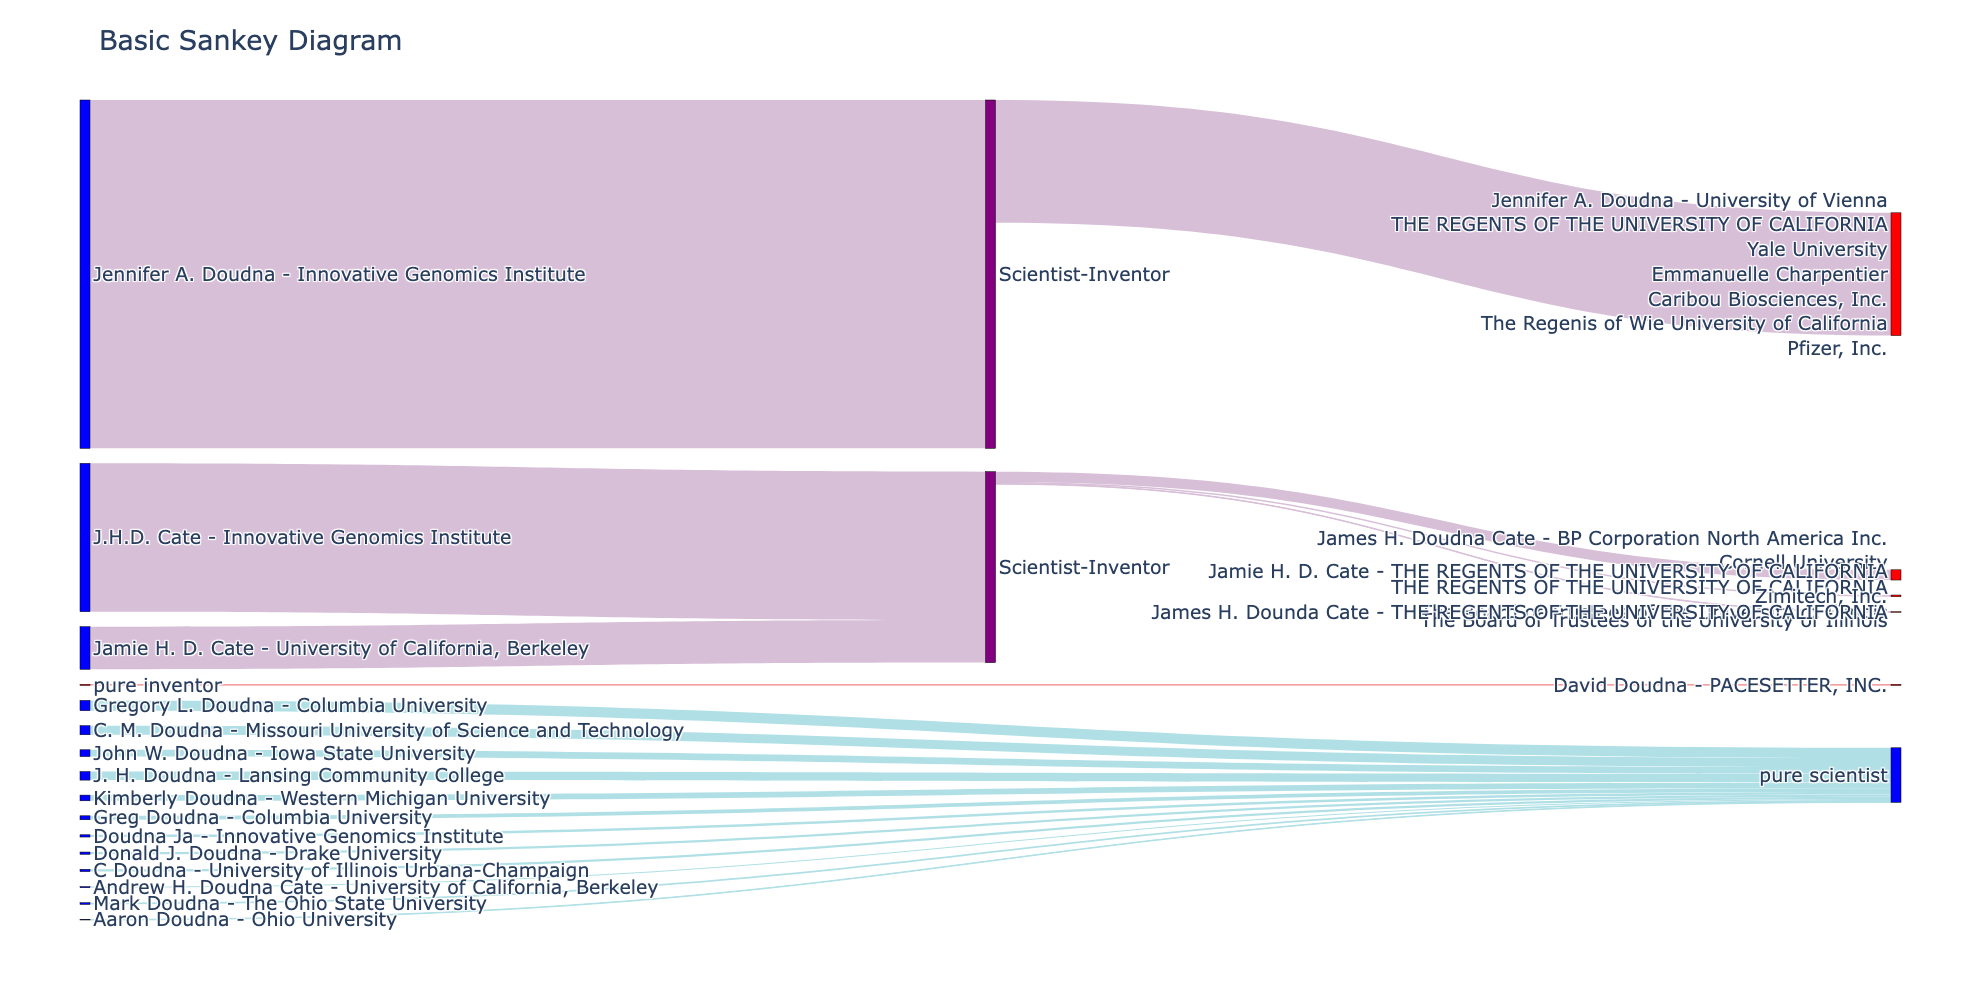

In [25]:
## plot the Sankey. Note: the nodes can be moved 

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 10,
      line = dict(color = "black", width = 0.5),
      label = label,
      color = color_nodes
    ),
    link = dict(
      source = source, 
      target = target,
      value = value,
      color = color_links  
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=19, width=2000, height=1000)
fig.show()